## initial mapping workflow for supratidal forests (STF)
- works on geojson GA coastal tiles `../data/geojson/ga_summary_grid_c3_coastal.geojson`
- confirm if to `export` results as tif

In [1]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# pd.set_option('display.max_rows', None)

sys.path.insert(1, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
dc = datacube.Datacube()

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

# custom functions
sys.path.insert(2, "/home/jovyan/code/supratidal_forests/functions")
import terrain


## user inputs: tile and export geotiffs?

In [2]:
# export as geotiff?
export = True

### using GA coastal tiles geojson

In [3]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

### select the tile of interest (click on map above and find value for `id` and manually select using `loc` below)

In [4]:
gdf = mainland_grid.loc[mainland_grid['id'] == 105]

In [5]:
gdf.explore()

In [6]:
# Create the 'query' dictionary object
res = (-30, 30)

# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

query = {
    "time": time_range,
    'resolution':res}

In [7]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

Feature: 105/1


### load strm and calculate slope

In [19]:
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h

In [20]:
# using dem_h here as results seem to be more alligned with QGIS slope function (gdaldem implementation)
# this throws warnings and results in some areas be 90 degrees slope (obviously wrong) around the edge of coastlines and rivers
# TODO: need to try with 'dem' and see what the issue is
shadows, slope, sia = terrain.shadows_and_slope(tile=srtm_ds.squeeze(), time=srtm_ds.dem.time.values, elevation_var='dem_h')

/home/jovyan/code/supratidal_forests/functions/terrain.py:126: RuntimeWarning: overflow encountered in multiply
  norm_len = numpy.sqrt((xgrad * xgrad) + (ygrad * ygrad) + 1.0)
/home/jovyan/code/supratidal_forests/functions/terrain.py:132: RuntimeWarning: invalid value encountered in subtract
  sia = (solar_vec[2] - (xgrad * solar_vec[0]) - (ygrad * solar_vec[1])) / norm_len
/home/jovyan/code/supratidal_forests/functions/terrain.py:132: RuntimeWarning: invalid value encountered in divide
  sia = (solar_vec[2] - (xgrad * solar_vec[0]) - (ygrad * solar_vec[1])) / norm_len


In [21]:
slope_xr = xr.DataArray(data=slope, coords=srtm_ds.squeeze().coords, dims=srtm_ds.squeeze().dims, attrs=srtm_ds.squeeze().attrs)

In [22]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, srtm_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
slope_xr_mask = slope_xr.where(mask)

# remove wrong values #
# strm dem h remove anything < -10
# srtm slope remove ==90


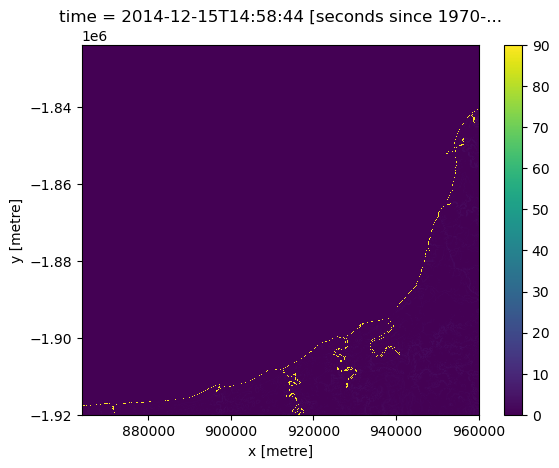

In [23]:
slope_xr_mask.plot()

### output to 2 band xarray dataset for srtm and slope
- band 1: SRTM
- band 2: slope

In [25]:
# make all into datasets and merge
variables_xarray_list = []

# band 1
# srtm_false_value_remove = xr.where(srtm < -10 ,0, srtm.values)
# srtm_ds = srtm_false_value_remove.to_dataset(name="SRTM").squeeze().drop('time')
srtm_ds = srtm_ds['dem_h'].to_dataset(name="SRTM").squeeze().drop('time')
variables_xarray_list.append(srtm_ds)
# variables_xarray_list.append(srtm_ds.dem_h.squeeze().drop('time'))


# band 2
slope_xr_false_value_remove = xr.where(slope_xr == 90 , 0, slope_xr.values)

slope_xr_ds = slope_xr.to_dataset(name="slope").squeeze().drop('time')
variables_xarray_list.append(slope_xr_ds)

stacked_xarray = xr.merge(variables_xarray_list)

In [31]:
srtm_ds.min()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 3577
Data variables:
    SRTM         float64 -3.403e+38

### output to geotiff

In [26]:
def set_band_names(input_img: str, band_names: list, feedback: bool = False):
    """
    NOTE: Function is from RSGISlib that is not avaliable on DEA sandbox
    A utility function to set band names.

    :param input_img: input image file.
    :param band_names: is a list of band names
    :param feedback: is a boolean specifying whether feedback will be printed to the
                     console (True= Printed / False (default) Not Printed)

    .. code:: python

        from rsgislib import imageutils

        input_img = 'injune_p142_casi_sub_utm.kea'
        band_names = ['446nm','530nm','549nm','569nm','598nm','633nm','680nm','696nm',
                      '714nm','732nm','741nm','752nm','800nm','838nm']

        imageutils.set_band_names(input_img, band_names)

    """
    dataset = gdal.Open(input_img, gdal.GA_Update)

    for i in range(len(band_names)):
        band = i + 1
        bandName = band_names[i]

        imgBand = dataset.GetRasterBand(band)
        # Check the image band is available
        if not imgBand is None:
            if feedback:
                print('Setting Band {0} to "{1}"'.format(band, bandName))
            imgBand.SetDescription(bandName)
        else:
            raise rsgislib.RSGISPyException("Could not open the image band: ", band)


In [27]:
stacked_xarray

<xarray.Dataset>
Dimensions:      (y: 3201, x: 3201)
Coordinates:
  * y            (y) float64 -1.824e+06 -1.824e+06 ... -1.92e+06 -1.92e+06
  * x            (x) float64 8.64e+05 8.64e+05 8.64e+05 ... 9.6e+05 9.6e+05
    spatial_ref  int32 3577
Data variables:
    SRTM         (y, x) float32 -3.403e+38 -3.403e+38 -3.403e+38 ... 8.853 8.979
    slope        (y, x) float32 0.0 0.0 0.0 0.0 ... 0.4878 0.1791 0.2185 0.2238

In [28]:
if export == False:
    pass
else:
    write_cog(geo_im=stacked_xarray.to_array(),
              fname='SRTM_slope_' + gdf['id'].astype(str).item() +'.tif',
              overwrite=True,
              nodata=0.0)

    input_img = 'SRTM_slope_' + gdf['id'].astype(str).item() +'.tif',
    band_names = list(stacked_xarray.data_vars.keys())
    set_band_names(input_img, band_names)

RuntimeError: not a string